In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

# Data Cleaning & Preparation

## Import dataset

In [2]:
df=pd.read_csv(r'C:\Study\Final Project\breast-cancer.csv')

## Drop the useless column (The id columns is useless)

In [3]:
df_clean=df.drop('id',axis=1)  

## Convert the string values to numeric (The Class column "diagnosis" is the only one)

In [4]:
df_clean['diagnosis']=df_clean['diagnosis'].map({'M':1, 'B':0})

# Correlation

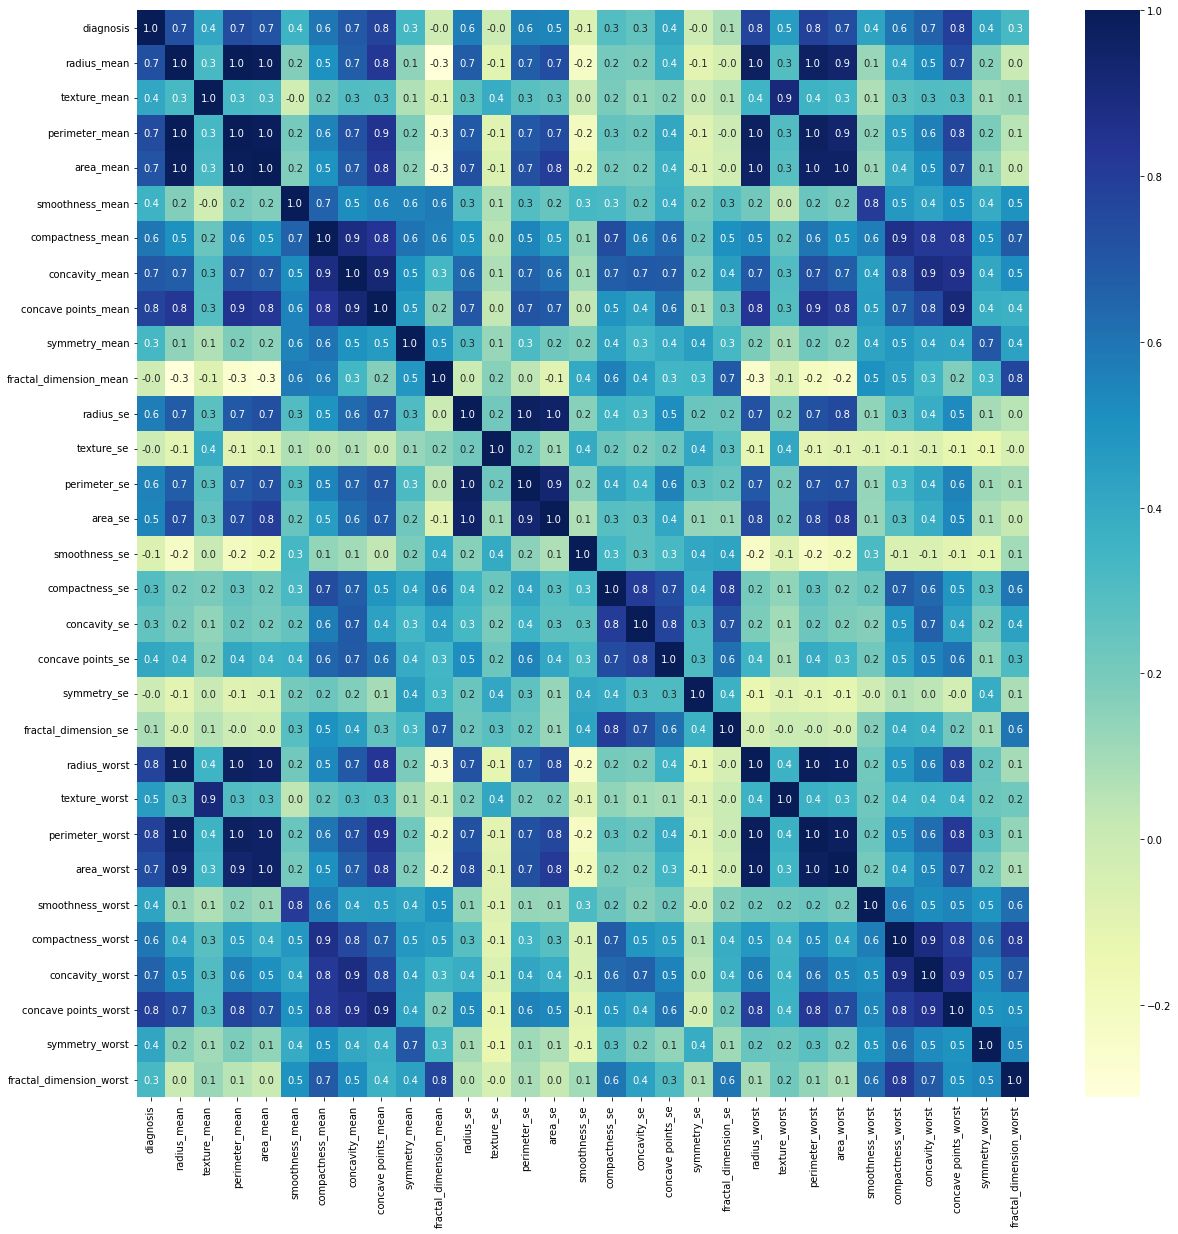

In [5]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(df_clean.corr(),annot=True,cmap='YlGnBu',fmt='.1f')
plt.rcParams['figure.facecolor'] = 'white'

In [6]:
cor=df_clean.corr()
cor=cor.reset_index().iloc[:,:2]
cor=cor[cor['index']!='diagnosis']
cor=cor.rename(columns={'index': 'Features', 'diagnosis': 'Correlation'})
cor['Correlation']=cor['Correlation'].apply(lambda x:abs(x))
cor=cor.sort_values('Correlation', ascending=False).reset_index(drop=True)
cor

,Features,Correlation
0,concave points_worst,0.793566
1,perimeter_worst,0.782914
2,concave points_mean,0.776614
3,radius_worst,0.776454
4,perimeter_mean,0.742636
5,area_worst,0.733825
6,radius_mean,0.730029
7,area_mean,0.708984
8,concavity_mean,0.696360
9,concavity_worst,0.659610


# Gain Ratio feature selection method to select features

### Calculate Entropy

In [7]:
def entropy(col, c=False):
    feature=df_clean[col]
    if c==True:
        pros=feature.value_counts(normalize=True)
        return -1 * np.sum(np.log2(pros) * pros)
    else:
        threshold=np.mean(feature)
        weight_less=df_clean[df_clean[col] <= threshold]
        weight_more=df_clean[df_clean[col] > threshold]
        
        p=[len(weight_less) / len(df_clean), len(weight_more) / len(df_clean)]
        
        entro_less=0
        entro_more=0
        for d in df_clean['diagnosis'].unique():
            weight_less_dia=weight_less[weight_less['diagnosis']==d]
            r_less=len(weight_less_dia) / len(weight_less)
            entro_less -= np.log2(r_less) * r_less
            
            weight_more_dia=weight_more[weight_more['diagnosis']==d]
            r_more=len(weight_more_dia) / len(weight_more)
            entro_more -= np.log2(r_more) * r_more
        
        return p[0] * entro_less + p[1] * entro_more   
            

In [8]:
entropy_class=entropy('diagnosis',c=True)
print('The entropy of class (diagnosis) is: %.2f' % entropy_class)

The entropy of class (diagnosis) is: 0.95


### Calculate Inforamtion Gain

In [9]:
def info_gain(col):
    return entropy_class-entropy(col)

### Calculate Spint Information

In [10]:
def split_info(col):
    feature=df_clean[col]
    threshold=np.mean(feature)
    weight_less=df_clean[df_clean[col] <= threshold]
    weight_more=df_clean[df_clean[col] > threshold]
    
    pros=pd.Series([len(weight_less) / len(df_clean), len(weight_more) / len(df_clean)])
    return -1 * np.sum(np.log2(pros) * pros)
    

### Calculate Gain Raio

In [11]:
def gain_ratio(col):
    return info_gain(col) / split_info(col)

In [12]:
cols=df_clean.columns[1:]
gain_ratios=[gain_ratio(col) for col in cols]

gainRatio=pd.DataFrame({'Features':cols, 'Gain Ratio': gain_ratios})
gainRatio.sort_values('Gain Ratio',ascending=False).reset_index(drop=True)

,Features,Gain Ratio
0,area_worst,0.608610
1,perimeter_worst,0.572704
2,concave points_mean,0.557111
3,radius_worst,0.535973
4,concave points_worst,0.504907
5,concavity_mean,0.464539
6,area_se,0.460266
7,perimeter_mean,0.425254
8,area_mean,0.423334
9,radius_mean,0.405891


In [13]:
gainRatio_corr=gainRatio.merge(cor, on='Features')
gainRatio_corr.sort_values(['Gain Ratio', 'Correlation'], ascending=False).reset_index(drop=True)

,Features,Gain Ratio,Correlation
0,area_worst,0.608610,0.733825
1,perimeter_worst,0.572704,0.782914
2,concave points_mean,0.557111,0.776614
3,radius_worst,0.535973,0.776454
4,concave points_worst,0.504907,0.793566
5,concavity_mean,0.464539,0.696360
6,area_se,0.460266,0.548236
7,perimeter_mean,0.425254,0.742636
8,area_mean,0.423334,0.708984
9,radius_mean,0.405891,0.730029


# Feature Selection

In [14]:
selected_features=gainRatio[gainRatio['Gain Ratio']>0.2]['Features'] # Select the features whose gain ratio are greater than 0.2

df_clean=df_clean[['diagnosis']+selected_features.to_list()]

## Scale data

### Check the range of every features

In [15]:
ranges=pd.DataFrame({'Column': df_clean.columns,
                     'Min': [df_clean[col].min() for col in df_clean.columns],
                     'Max': [df_clean[col].max() for col in df_clean.columns]})

In [16]:
ranges

,Column,Min,Max
0,diagnosis,0.00000,1.0000
1,radius_mean,6.98100,28.1100
2,perimeter_mean,43.79000,188.5000
3,area_mean,143.50000,2501.0000
4,compactness_mean,0.01938,0.3454
5,concavity_mean,0.00000,0.4268
6,concave points_mean,0.00000,0.2012
7,radius_se,0.11150,2.8730
8,perimeter_se,0.75700,21.9800
9,area_se,6.80200,542.2000


### Some columns have large ranges and not all the columns stay at the same level. So the dataset need to be scaled.

In [17]:
scaler=MinMaxScaler()
df_scaled=pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

In [18]:
df_scaled.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,1.0,0.521037,0.545989,0.363733,0.792037,0.703140,0.731113,0.356147,0.369034,0.273811,0.620776,0.668310,0.450698,0.619292,0.568610,0.912027
1,1.0,0.643144,0.615783,0.501591,0.181768,0.203608,0.348757,0.156437,0.124440,0.125660,0.606901,0.539818,0.435214,0.154563,0.192971,0.639175
2,1.0,0.601496,0.595743,0.449417,0.431017,0.462512,0.635686,0.229622,0.180370,0.162922,0.556386,0.508442,0.374508,0.385375,0.359744,0.835052
3,1.0,0.210090,0.233501,0.102906,0.811361,0.565604,0.522863,0.139091,0.126655,0.038155,0.248310,0.241347,0.094008,0.814012,0.548642,0.884880
4,1.0,0.629893,0.630986,0.489290,0.347893,0.463918,0.518390,0.233822,0.220563,0.163688,0.519744,0.506948,0.341575,0.172415,0.319489,0.558419


## Split the dataset (70% training vs 30% test)

In [19]:
X=df_scaled.iloc[:,1:].values
y=df_scaled.iloc[:,0].values

In [20]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

# Build Models

In [21]:
lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

# Review the models' performance with accuracy and cross validation score

In [22]:
def model_performance(model):
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    accuracy=accuracy_score(y_test,prediction)
    
    sk_folders=StratifiedKFold(n_splits=5)
    cv_scores=cross_val_score(model, X, y, cv=sk_folders).mean()
    return accuracy,cv_scores

In [23]:
performances_70_30=pd.DataFrame()
performances_70_30['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_70_30['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_70_30['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

In [24]:
performances_70_30

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.941520,0.934995
1,Decision Tree,0.935673,0.924530
2,Random Forest,0.959064,0.942043
3,KNN,0.947368,0.938519
4,Gaussian Naive Bayes,0.935673,0.929731


Text(0.5, 1.0, 'Accuracy & CV Scores by 70%-30% split')

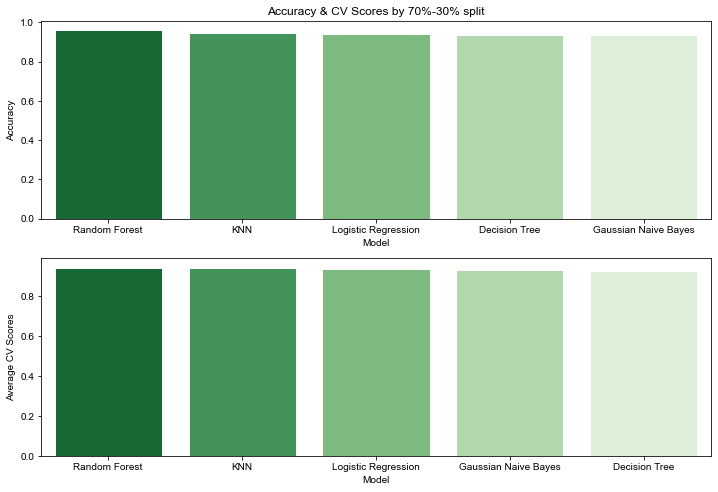

In [25]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens", len(performances_70_30))
sns.barplot(x='Model', y='Accuracy', data=performances_70_30.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_70_30.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 70%-30% split')

# Do the same thing with splitting dataset as 60% training and 40% test

In [26]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.4, random_state=42)

lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

performances_60_40=pd.DataFrame()
performances_60_40['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_60_40['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_60_40['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

performances_60_40

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.942982,0.934995
1,Decision Tree,0.929825,0.913957
2,Random Forest,0.951754,0.945552
3,KNN,0.951754,0.938519
4,Gaussian Naive Bayes,0.942982,0.929731


Text(0.5, 1.0, 'Accuracy & CV Scores by 60%-40% split')

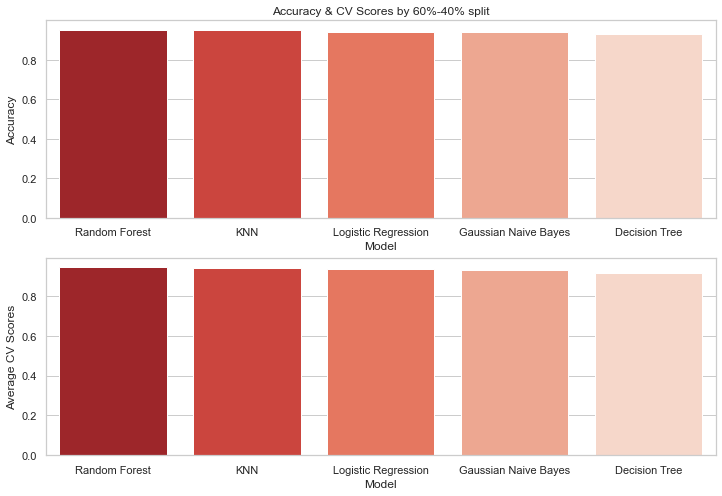

In [27]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Reds", len(performances_60_40))
sns.barplot(x='Model', y='Accuracy', data=performances_60_40.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_60_40.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 60%-40% split')

# Do the same thing with splitting dataset as 80% training and 20% test

In [28]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

lr=LogisticRegression()                #Logistic Regression Model
dt=DecisionTreeClassifier()            #Decision Tree Classification Model
rf=RandomForestClassifier()            #Radom Forest Classification Model
kn=KNeighborsClassifier()              #KNN Classification Model
gb=GaussianNB()                        #Gaussian Naive Bayes Model

performances_80_20=pd.DataFrame()
performances_80_20['Model']=['Logistic Regression','Decision Tree','Random Forest','KNN','Gaussian Naive Bayes']
performances_80_20['Accuracy']=[model_performance(lr)[0],
                          model_performance(dt)[0],
                          model_performance(rf)[0],
                          model_performance(kn)[0],
                          model_performance(gb)[0]]
performances_80_20['Average CV Scores']=[model_performance(lr)[1],
                                   model_performance(dt)[1],
                                   model_performance(rf)[1],
                                   model_performance(kn)[1],
                                   model_performance(gb)[1]]

performances_80_20

,Model,Accuracy,Average CV Scores
0,Logistic Regression,0.956140,0.934995
1,Decision Tree,0.938596,0.924499
2,Random Forest,0.964912,0.947306
3,KNN,0.964912,0.938519
4,Gaussian Naive Bayes,0.964912,0.929731


Text(0.5, 1.0, 'Accuracy & CV Scores by 80%-20% split')

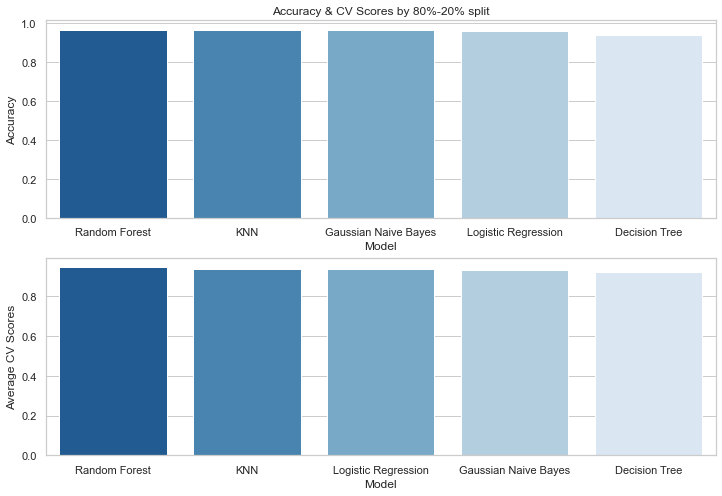

In [29]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues", len(performances_80_20))
sns.barplot(x='Model', y='Accuracy', data=performances_80_20.sort_values('Accuracy', ascending=False), ax=axes[0], palette=np.array(pal[::-1]))
sns.barplot(x='Model', y='Average CV Scores', data=performances_80_20.sort_values('Average CV Scores', ascending=False), ax=axes[1], palette=np.array(pal[::-1]))
axes[0].set_title(r'Accuracy & CV Scores by 80%-20% split')

In [30]:
performances=pd.concat([performances_70_30, performances_60_40, performances_80_20],ignore_index=True)
performances['Split']=['70-30']*5 + ['60-40']*5 + ['80-20'] * 5

performances.sort_values('Average CV Scores', ascending=False)

,Model,Accuracy,Average CV Scores,Split
12,Random Forest,0.964912,0.947306,80-20
7,Random Forest,0.951754,0.945552,60-40
2,Random Forest,0.959064,0.942043,70-30
3,KNN,0.947368,0.938519,70-30
8,KNN,0.951754,0.938519,60-40
13,KNN,0.964912,0.938519,80-20
0,Logistic Regression,0.941520,0.934995,70-30
5,Logistic Regression,0.942982,0.934995,60-40
10,Logistic Regression,0.956140,0.934995,80-20
4,Gaussian Naive Bayes,0.935673,0.929731,70-30


Text(0.5, 1.0, 'Accuracy & CV Scores')

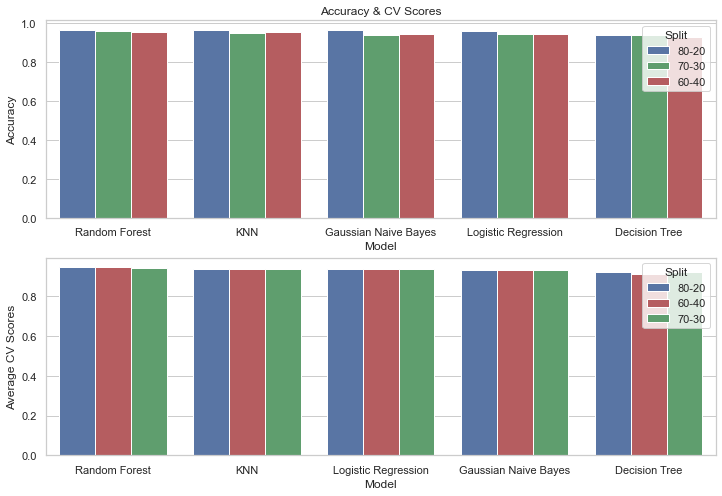

In [31]:
fig, axes=plt.subplots(2, 1, figsize=(12, 8))
sns.set(style="whitegrid", color_codes=True)

palette={'70-30': 'g',
         '60-40': 'r',
         '80-20': 'b'}
sns.barplot(x='Model', y='Accuracy', data=performances.sort_values('Accuracy', ascending=False), ax=axes[0], hue='Split', palette=palette)
sns.barplot(x='Model', y='Average CV Scores', data=performances.sort_values('Average CV Scores', ascending=False), ax=axes[1], hue='Split', palette=palette)
axes[0].set_title(r'Accuracy & CV Scores')


### Conclusion: The Random Forest model is the best choice on this topic.